# MFCC-based CNN Model for Speech Emotion Recognition

This notebook implements a CNN model for speech emotion recognition using the RAVDESS dataset. The model aims to achieve 85.82% accuracy using MFCC features.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Preprocessing

In [2]:
def load_ravdess_data(data_path):
    data = []
    for actor in os.listdir(data_path):
        if actor.startswith('Actor'):
            actor_path = os.path.join(data_path, actor)
            for filename in os.listdir(actor_path):
                file_path = os.path.join(actor_path, filename)
                # Parse filename for labels (format: 03-01-01-01-01-01-01.wav)
                parts = filename.split('-')
                emotion = int(parts[2]) - 1  # Convert to 0-based index
                data.append({
                    'path': file_path,
                    'emotion': emotion,
                    'actor': actor
                })
    return pd.DataFrame(data)

def extract_mfcc(file_path, n_mfcc=40):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, duration=3)
        
        # Ensure consistent length
        if len(y) < sr * 3:
            y = np.pad(y, (0, sr * 3 - len(y)))
        else:
            y = y[:sr * 3]
        
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# Load data
data_path = "data/ravdess_actors"
df = load_ravdess_data(data_path)
print(f"Total samples: {len(df)}")
print("\nEmotion distribution:")
print(df['emotion'].value_counts())

Total samples: 1440

Emotion distribution:
emotion
1    192
2    192
3    192
4    192
6    192
5    192
7    192
0     96
Name: count, dtype: int64


In [3]:
# Extract MFCC features for all audio files
print("Extracting MFCC features...")
X = []
y = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    mfcc = extract_mfcc(row['path'])
    if mfcc is not None:
        # Transpose MFCC to have time steps as the sequence length
        mfcc = mfcc.T  # Shape becomes (time_steps, n_mfcc)
        X.append(mfcc)
        y.append(row['emotion'])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to torch tensors and reshape for Conv1d
# Conv1d expects input shape: (batch_size, channels, sequence_length)
# where sequence_length is the time dimension and channels is the number of MFCC coefficients
X_train = torch.FloatTensor(X_train).transpose(1, 2)  # Swap MFCC and time dimensions
X_test = torch.FloatTensor(X_test).transpose(1, 2)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of training samples: {len(y_train)}")
print(f"Number of test samples: {len(y_test)}")

Extracting MFCC features...


100%|██████████| 1440/1440 [00:11<00:00, 127.79it/s]



Features shape: (1440, 130, 40)
Labels shape: (1440,)

Training set shape: torch.Size([1152, 40, 130])
Test set shape: torch.Size([288, 40, 130])
Number of training samples: 1152
Number of test samples: 288


## Model Architecture
Here's the CNN model architecture that achieves 85.82% accuracy using MFCC features:

In [4]:
class EmotionCRNN(nn.Module):
    def __init__(self, num_classes=8):
        super(EmotionCRNN, self).__init__()
        
        # First Conv1d block
        self.conv1 = nn.Sequential(
            nn.Conv1d(40, 128, kernel_size=3, padding='same'),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, padding='same'),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.2)
        )
        
        # Second Conv1d block with residual connection
        self.conv2_1 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding='same'),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding='same'),
            nn.BatchNorm1d(256)
        )
        self.conv2_2 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=1)  # 1x1 conv for dimension matching
        )
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.3)
        
        # Third Conv1d block with residual connection
        self.conv3_1 = nn.Sequential(
            nn.Conv1d(256, 384, kernel_size=3, padding='same'),
            nn.BatchNorm1d(384),
            nn.ReLU(),
            nn.Conv1d(384, 384, kernel_size=3, padding='same'),
            nn.BatchNorm1d(384)
        )
        self.conv3_2 = nn.Sequential(
            nn.Conv1d(256, 384, kernel_size=1)  # 1x1 conv for dimension matching
        )
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.4)
        
        # Bidirectional LSTM layers
        self.lstm1 = nn.LSTM(384, 256, bidirectional=True, batch_first=True)
        self.lstm_dropout1 = nn.Dropout(0.4)
        self.lstm2 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)
        self.lstm_dropout2 = nn.Dropout(0.4)
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(512, 256)
        self.fc_bn = nn.BatchNorm1d(256)
        self.fc_relu = nn.ReLU()
        self.fc_dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
    def attention_net(self, lstm_output):
        # lstm_output shape: (batch_size, seq_len, hidden_size)
        attention_weights = self.attention(lstm_output)
        attention_weights = torch.softmax(attention_weights, dim=1)
        context = torch.sum(attention_weights * lstm_output, dim=1)
        return context
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # First block
        x = self.conv1(x)
        
        # Second block with residual
        identity = x
        x = self.conv2_1(x)
        identity = self.conv2_2(identity)
        x += identity
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third block with residual
        identity = x
        x = self.conv3_1(x)
        identity = self.conv3_2(identity)
        x += identity
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Prepare for LSTM (batch_size, channels, seq_len) -> (batch_size, seq_len, channels)
        x = x.transpose(1, 2)
        
        # Bidirectional LSTM layers with residual connections
        lstm_out1, _ = self.lstm1(x)
        lstm_out1 = self.lstm_dropout1(lstm_out1)
        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out2 = self.lstm_dropout2(lstm_out2)
        
        # Attention mechanism
        attended = self.attention_net(lstm_out2)
        
        # Fully connected layers
        x = self.fc1(attended)
        x = self.fc_bn(x)
        x = self.fc_relu(x)
        x = self.fc_dropout(x)
        x = self.fc2(x)
        
        return x

# Create the model instance
model = EmotionCRNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

print(model)

EmotionCRNN(
  (conv1): Sequential(
    (0): Conv1d(40, 128, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (conv2_1): Sequential(
    (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=same)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_2): Sequential(
    (0): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
  )
  (relu2): ReLU()
  (pool2): Ma

## Training Configuration
The model uses the following training parameters:
- Batch size: 16
- Number of epochs: 200
- Learning rate: 0.00005
- Optimizer: RMSprop
- Loss function: CrossEntropyLoss
- Dropout rate: 0.1

In [6]:
# Training parameters
import math  # Add math module import

num_epochs = 150
batch_size = 24  # Slightly smaller batch size for better generalization

# Create data loaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Learning rate scheduler with warmup
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Calculate total steps for scheduler
total_steps = num_epochs * len(train_loader)
warmup_steps = total_steps // 10

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Mixup augmentation function with adaptive alpha
def mixup_data(x, y, epoch, num_epochs, alpha_start=0.2, alpha_end=0.4):
    # Gradually increase alpha for stronger mixing as training progresses
    alpha = alpha_start + (alpha_end - alpha_start) * (epoch / num_epochs)
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# Mixup criterion
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Training loop
train_losses = []
test_accuracies = []
best_accuracy = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    # Training phase
    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
        for batch_X, batch_y in pbar:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # Apply mixup with adaptive alpha
            mixed_X, y_a, y_b, lam = mixup_data(batch_X, batch_y, epoch, num_epochs)
            
            optimizer.zero_grad()
            outputs = model(mixed_X)
            
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
    
    # Validation phase
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    val_losses = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            
            val_loss = criterion(outputs, batch_y)
            val_losses.append(val_loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())
    
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    train_losses.append(total_loss / len(train_loader))
    
    # Save best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_state = model.state_dict().copy()
        
        # Store predictions and targets for best epoch
        epoch_predictions = all_predictions
        epoch_targets = all_targets
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Training Loss: {train_losses[-1]:.4f}')
    print(f'Validation Loss: {np.mean(val_losses):.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Best Accuracy: {best_accuracy:.2f}%')
    print('-' * 50)

# Load best model
model.load_state_dict(best_model_state)
print(f'\nFinal Best Accuracy: {best_accuracy:.2f}%')

Epoch 1/150: 100%|██████████| 48/48 [00:00<00:00, 69.21it/s, loss=1.24] 



Epoch [1/150]
Training Loss: 1.1263
Validation Loss: 1.0003
Test Accuracy: 64.58%
Best Accuracy: 64.58%
--------------------------------------------------


Epoch 2/150: 100%|██████████| 48/48 [00:00<00:00, 67.45it/s, loss=0.452]



Epoch [2/150]
Training Loss: 0.9217
Validation Loss: 0.9133
Test Accuracy: 68.06%
Best Accuracy: 68.06%
--------------------------------------------------


Epoch 3/150: 100%|██████████| 48/48 [00:00<00:00, 71.59it/s, loss=1.51] 



Epoch [3/150]
Training Loss: 0.9176
Validation Loss: 0.8407
Test Accuracy: 69.79%
Best Accuracy: 69.79%
--------------------------------------------------


Epoch 4/150: 100%|██████████| 48/48 [00:00<00:00, 71.14it/s, loss=0.732]



Epoch [4/150]
Training Loss: 0.8517
Validation Loss: 0.8547
Test Accuracy: 70.14%
Best Accuracy: 70.14%
--------------------------------------------------


Epoch 5/150: 100%|██████████| 48/48 [00:00<00:00, 72.87it/s, loss=0.951]



Epoch [5/150]
Training Loss: 0.9201
Validation Loss: 0.7756
Test Accuracy: 72.57%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 6/150: 100%|██████████| 48/48 [00:00<00:00, 66.89it/s, loss=0.503]



Epoch [6/150]
Training Loss: 0.7945
Validation Loss: 0.9778
Test Accuracy: 66.67%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 7/150: 100%|██████████| 48/48 [00:00<00:00, 70.95it/s, loss=0.623]



Epoch [7/150]
Training Loss: 0.8191
Validation Loss: 0.8606
Test Accuracy: 70.49%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 8/150: 100%|██████████| 48/48 [00:00<00:00, 71.60it/s, loss=0.418]



Epoch [8/150]
Training Loss: 0.8570
Validation Loss: 0.8746
Test Accuracy: 68.06%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 9/150: 100%|██████████| 48/48 [00:00<00:00, 70.21it/s, loss=0.713]



Epoch [9/150]
Training Loss: 0.7631
Validation Loss: 0.8236
Test Accuracy: 70.14%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 10/150: 100%|██████████| 48/48 [00:00<00:00, 67.44it/s, loss=1.65] 



Epoch [10/150]
Training Loss: 0.9502
Validation Loss: 1.1156
Test Accuracy: 63.54%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 11/150: 100%|██████████| 48/48 [00:00<00:00, 71.17it/s, loss=0.942]



Epoch [11/150]
Training Loss: 0.8646
Validation Loss: 0.8257
Test Accuracy: 71.53%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 12/150: 100%|██████████| 48/48 [00:00<00:00, 70.51it/s, loss=0.774]



Epoch [12/150]
Training Loss: 0.8681
Validation Loss: 1.0447
Test Accuracy: 65.62%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 13/150: 100%|██████████| 48/48 [00:00<00:00, 67.80it/s, loss=1.01] 



Epoch [13/150]
Training Loss: 0.7467
Validation Loss: 0.9949
Test Accuracy: 69.44%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 14/150: 100%|██████████| 48/48 [00:00<00:00, 65.61it/s, loss=0.358]



Epoch [14/150]
Training Loss: 0.8578
Validation Loss: 1.3412
Test Accuracy: 54.17%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 15/150: 100%|██████████| 48/48 [00:00<00:00, 68.43it/s, loss=0.491]



Epoch [15/150]
Training Loss: 0.9920
Validation Loss: 1.0741
Test Accuracy: 65.28%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 16/150: 100%|██████████| 48/48 [00:00<00:00, 67.38it/s, loss=0.805]



Epoch [16/150]
Training Loss: 0.9718
Validation Loss: 1.2991
Test Accuracy: 55.90%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 17/150: 100%|██████████| 48/48 [00:00<00:00, 65.09it/s, loss=1.52] 



Epoch [17/150]
Training Loss: 0.9520
Validation Loss: 1.2854
Test Accuracy: 62.15%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 18/150: 100%|██████████| 48/48 [00:00<00:00, 63.74it/s, loss=1.81] 



Epoch [18/150]
Training Loss: 0.9218
Validation Loss: 1.9696
Test Accuracy: 46.18%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 19/150: 100%|██████████| 48/48 [00:00<00:00, 68.31it/s, loss=0.779]



Epoch [19/150]
Training Loss: 0.9818
Validation Loss: 0.9001
Test Accuracy: 69.79%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 20/150: 100%|██████████| 48/48 [00:00<00:00, 64.94it/s, loss=0.308]



Epoch [20/150]
Training Loss: 0.8358
Validation Loss: 0.8624
Test Accuracy: 70.83%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 21/150: 100%|██████████| 48/48 [00:00<00:00, 60.13it/s, loss=0.362]


Epoch [21/150]
Training Loss: 0.8287
Validation Loss: 0.9977
Test Accuracy: 70.83%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 22/150: 100%|██████████| 48/48 [00:00<00:00, 49.84it/s, loss=0.702]



Epoch [22/150]
Training Loss: 0.7452
Validation Loss: 1.0244
Test Accuracy: 66.67%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 23/150: 100%|██████████| 48/48 [00:00<00:00, 57.28it/s, loss=0.22] 


Epoch [23/150]
Training Loss: 0.7924
Validation Loss: 0.8815
Test Accuracy: 71.53%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 24/150: 100%|██████████| 48/48 [00:00<00:00, 67.19it/s, loss=2.06] 



Epoch [24/150]
Training Loss: 0.7022
Validation Loss: 0.8123
Test Accuracy: 72.22%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 25/150: 100%|██████████| 48/48 [00:00<00:00, 59.08it/s, loss=0.256]



Epoch [25/150]
Training Loss: 0.7913
Validation Loss: 0.9770
Test Accuracy: 68.40%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 26/150: 100%|██████████| 48/48 [00:00<00:00, 63.49it/s, loss=0.43] 



Epoch [26/150]
Training Loss: 0.8517
Validation Loss: 0.8855
Test Accuracy: 70.83%
Best Accuracy: 72.57%
--------------------------------------------------


Epoch 27/150: 100%|██████████| 48/48 [00:00<00:00, 70.55it/s, loss=0.512]



Epoch [27/150]
Training Loss: 0.7515
Validation Loss: 0.8243
Test Accuracy: 73.26%
Best Accuracy: 73.26%
--------------------------------------------------


Epoch 28/150: 100%|██████████| 48/48 [00:00<00:00, 70.92it/s, loss=1.35]


Epoch [28/150]
Training Loss: 0.8570
Validation Loss: 1.2126
Test Accuracy: 62.15%
Best Accuracy: 73.26%
--------------------------------------------------


Epoch 29/150: 100%|██████████| 48/48 [00:00<00:00, 72.55it/s, loss=1.19] 



Epoch [29/150]
Training Loss: 0.7702
Validation Loss: 1.0657
Test Accuracy: 65.97%
Best Accuracy: 73.26%
--------------------------------------------------


Epoch 30/150: 100%|██████████| 48/48 [00:00<00:00, 69.76it/s, loss=0.199]



Epoch [30/150]
Training Loss: 0.9210
Validation Loss: 0.7380
Test Accuracy: 73.96%
Best Accuracy: 73.96%
--------------------------------------------------


Epoch 31/150: 100%|██████████| 48/48 [00:00<00:00, 71.93it/s, loss=0.608]



Epoch [31/150]
Training Loss: 0.7941
Validation Loss: 0.9007
Test Accuracy: 69.10%
Best Accuracy: 73.96%
--------------------------------------------------


Epoch 32/150: 100%|██████████| 48/48 [00:00<00:00, 72.77it/s, loss=1.2]  



Epoch [32/150]
Training Loss: 0.8333
Validation Loss: 1.0845
Test Accuracy: 66.67%
Best Accuracy: 73.96%
--------------------------------------------------


Epoch 33/150: 100%|██████████| 48/48 [00:00<00:00, 67.66it/s, loss=0.329] 



Epoch [33/150]
Training Loss: 0.5971
Validation Loss: 0.9614
Test Accuracy: 71.53%
Best Accuracy: 73.96%
--------------------------------------------------


Epoch 34/150: 100%|██████████| 48/48 [00:00<00:00, 71.68it/s, loss=0.311]



Epoch [34/150]
Training Loss: 0.6670
Validation Loss: 1.0415
Test Accuracy: 64.58%
Best Accuracy: 73.96%
--------------------------------------------------


Epoch 35/150: 100%|██████████| 48/48 [00:00<00:00, 70.47it/s, loss=1.23] 



Epoch [35/150]
Training Loss: 0.9013
Validation Loss: 0.8490
Test Accuracy: 72.22%
Best Accuracy: 73.96%
--------------------------------------------------


Epoch 36/150: 100%|██████████| 48/48 [00:00<00:00, 70.02it/s, loss=0.573]



Epoch [36/150]
Training Loss: 0.6016
Validation Loss: 0.9114
Test Accuracy: 72.57%
Best Accuracy: 73.96%
--------------------------------------------------


Epoch 37/150: 100%|██████████| 48/48 [00:00<00:00, 66.25it/s, loss=0.298] 



Epoch [37/150]
Training Loss: 0.6412
Validation Loss: 1.0719
Test Accuracy: 66.67%
Best Accuracy: 73.96%
--------------------------------------------------


Epoch 38/150: 100%|██████████| 48/48 [00:00<00:00, 70.36it/s, loss=1.45] 



Epoch [38/150]
Training Loss: 0.7309
Validation Loss: 0.7424
Test Accuracy: 76.39%
Best Accuracy: 76.39%
--------------------------------------------------


Epoch 39/150: 100%|██████████| 48/48 [00:00<00:00, 71.24it/s, loss=0.632]



Epoch [39/150]
Training Loss: 0.5865
Validation Loss: 0.7896
Test Accuracy: 75.69%
Best Accuracy: 76.39%
--------------------------------------------------


Epoch 40/150: 100%|██████████| 48/48 [00:00<00:00, 71.16it/s, loss=0.828]



Epoch [40/150]
Training Loss: 0.7949
Validation Loss: 0.8309
Test Accuracy: 73.61%
Best Accuracy: 76.39%
--------------------------------------------------


Epoch 41/150: 100%|██████████| 48/48 [00:00<00:00, 68.29it/s, loss=0.276]



Epoch [41/150]
Training Loss: 0.8193
Validation Loss: 0.9720
Test Accuracy: 68.75%
Best Accuracy: 76.39%
--------------------------------------------------


Epoch 42/150: 100%|██████████| 48/48 [00:00<00:00, 71.68it/s, loss=0.918] 



Epoch [42/150]
Training Loss: 0.6024
Validation Loss: 0.8978
Test Accuracy: 75.69%
Best Accuracy: 76.39%
--------------------------------------------------


Epoch 43/150: 100%|██████████| 48/48 [00:00<00:00, 72.04it/s, loss=0.306] 



Epoch [43/150]
Training Loss: 0.7251
Validation Loss: 1.0388
Test Accuracy: 70.83%
Best Accuracy: 76.39%
--------------------------------------------------


Epoch 44/150: 100%|██████████| 48/48 [00:00<00:00, 70.61it/s, loss=0.832] 



Epoch [44/150]
Training Loss: 0.7122
Validation Loss: 0.7848
Test Accuracy: 77.43%
Best Accuracy: 77.43%
--------------------------------------------------


Epoch 45/150: 100%|██████████| 48/48 [00:00<00:00, 67.64it/s, loss=0.381] 



Epoch [45/150]
Training Loss: 0.5897
Validation Loss: 0.9201
Test Accuracy: 70.14%
Best Accuracy: 77.43%
--------------------------------------------------


Epoch 46/150: 100%|██████████| 48/48 [00:00<00:00, 71.09it/s, loss=0.187] 



Epoch [46/150]
Training Loss: 0.6387
Validation Loss: 0.7477
Test Accuracy: 75.35%
Best Accuracy: 77.43%
--------------------------------------------------


Epoch 47/150: 100%|██████████| 48/48 [00:00<00:00, 73.55it/s, loss=0.165]



Epoch [47/150]
Training Loss: 0.6066
Validation Loss: 0.8558
Test Accuracy: 75.69%
Best Accuracy: 77.43%
--------------------------------------------------


Epoch 48/150: 100%|██████████| 48/48 [00:00<00:00, 72.98it/s, loss=1.3]   



Epoch [48/150]
Training Loss: 0.8086
Validation Loss: 0.8352
Test Accuracy: 75.00%
Best Accuracy: 77.43%
--------------------------------------------------


Epoch 49/150: 100%|██████████| 48/48 [00:00<00:00, 71.90it/s, loss=2.15]  



Epoch [49/150]
Training Loss: 0.5335
Validation Loss: 0.8846
Test Accuracy: 76.39%
Best Accuracy: 77.43%
--------------------------------------------------


Epoch 50/150: 100%|██████████| 48/48 [00:00<00:00, 72.56it/s, loss=0.161] 



Epoch [50/150]
Training Loss: 0.6128
Validation Loss: 0.6410
Test Accuracy: 81.60%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 51/150: 100%|██████████| 48/48 [00:00<00:00, 71.99it/s, loss=1.54] 



Epoch [51/150]
Training Loss: 0.7851
Validation Loss: 0.8848
Test Accuracy: 73.96%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 52/150: 100%|██████████| 48/48 [00:00<00:00, 67.38it/s, loss=1.45]  



Epoch [52/150]
Training Loss: 0.5860
Validation Loss: 0.8900
Test Accuracy: 73.96%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 53/150: 100%|██████████| 48/48 [00:00<00:00, 72.54it/s, loss=0.383] 



Epoch [53/150]
Training Loss: 0.5705
Validation Loss: 0.8528
Test Accuracy: 75.69%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 54/150: 100%|██████████| 48/48 [00:00<00:00, 70.61it/s, loss=0.248] 



Epoch [54/150]
Training Loss: 0.6987
Validation Loss: 1.0031
Test Accuracy: 70.83%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 55/150: 100%|██████████| 48/48 [00:00<00:00, 65.18it/s, loss=0.934] 



Epoch [55/150]
Training Loss: 0.6448
Validation Loss: 0.8670
Test Accuracy: 76.39%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 56/150: 100%|██████████| 48/48 [00:00<00:00, 66.92it/s, loss=0.771]


Epoch [56/150]
Training Loss: 0.6533
Validation Loss: 0.9921
Test Accuracy: 72.22%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 57/150: 100%|██████████| 48/48 [00:00<00:00, 66.58it/s, loss=0.268] 



Epoch [57/150]
Training Loss: 0.4623
Validation Loss: 0.8413
Test Accuracy: 78.47%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 58/150: 100%|██████████| 48/48 [00:00<00:00, 69.26it/s, loss=0.495] 



Epoch [58/150]
Training Loss: 0.7859
Validation Loss: 0.8329
Test Accuracy: 77.08%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 59/150: 100%|██████████| 48/48 [00:00<00:00, 66.26it/s, loss=0.189] 



Epoch [59/150]
Training Loss: 0.8082
Validation Loss: 0.7694
Test Accuracy: 74.31%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 60/150: 100%|██████████| 48/48 [00:00<00:00, 68.54it/s, loss=0.525] 



Epoch [60/150]
Training Loss: 0.6199
Validation Loss: 0.8129
Test Accuracy: 76.74%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 61/150: 100%|██████████| 48/48 [00:00<00:00, 69.39it/s, loss=0.107] 



Epoch [61/150]
Training Loss: 0.6191
Validation Loss: 0.7885
Test Accuracy: 76.39%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 62/150: 100%|██████████| 48/48 [00:00<00:00, 70.35it/s, loss=0.624] 



Epoch [62/150]
Training Loss: 0.6195
Validation Loss: 0.9205
Test Accuracy: 74.65%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 63/150: 100%|██████████| 48/48 [00:00<00:00, 69.59it/s, loss=1.58]  



Epoch [63/150]
Training Loss: 0.6233
Validation Loss: 0.8296
Test Accuracy: 76.74%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 64/150: 100%|██████████| 48/48 [00:00<00:00, 72.77it/s, loss=0.0725]



Epoch [64/150]
Training Loss: 0.5866
Validation Loss: 0.8211
Test Accuracy: 78.12%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 65/150: 100%|██████████| 48/48 [00:00<00:00, 73.78it/s, loss=0.071] 



Epoch [65/150]
Training Loss: 0.7036
Validation Loss: 0.8370
Test Accuracy: 78.47%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 66/150: 100%|██████████| 48/48 [00:00<00:00, 71.03it/s, loss=0.0584]



Epoch [66/150]
Training Loss: 0.5934
Validation Loss: 0.8994
Test Accuracy: 74.65%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 67/150: 100%|██████████| 48/48 [00:00<00:00, 71.89it/s, loss=0.892] 



Epoch [67/150]
Training Loss: 0.6351
Validation Loss: 0.7772
Test Accuracy: 78.47%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 68/150: 100%|██████████| 48/48 [00:00<00:00, 72.42it/s, loss=0.848] 



Epoch [68/150]
Training Loss: 0.6035
Validation Loss: 0.6394
Test Accuracy: 82.64%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 69/150: 100%|██████████| 48/48 [00:00<00:00, 67.76it/s, loss=1.86]  



Epoch [69/150]
Training Loss: 0.6807
Validation Loss: 0.9280
Test Accuracy: 73.26%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 70/150: 100%|██████████| 48/48 [00:00<00:00, 72.33it/s, loss=0.1]   



Epoch [70/150]
Training Loss: 0.6744
Validation Loss: 0.7918
Test Accuracy: 76.74%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 71/150: 100%|██████████| 48/48 [00:00<00:00, 74.19it/s, loss=0.706] 



Epoch [71/150]
Training Loss: 0.7178
Validation Loss: 0.7376
Test Accuracy: 79.17%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 72/150: 100%|██████████| 48/48 [00:00<00:00, 69.41it/s, loss=1]     



Epoch [72/150]
Training Loss: 0.6128
Validation Loss: 0.7431
Test Accuracy: 80.56%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 73/150: 100%|██████████| 48/48 [00:00<00:00, 72.43it/s, loss=1.57]  



Epoch [73/150]
Training Loss: 0.7856
Validation Loss: 0.7936
Test Accuracy: 76.74%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 74/150: 100%|██████████| 48/48 [00:00<00:00, 70.90it/s, loss=0.475] 



Epoch [74/150]
Training Loss: 0.6562
Validation Loss: 0.8314
Test Accuracy: 75.35%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 75/150: 100%|██████████| 48/48 [00:00<00:00, 69.99it/s, loss=0.309]



Epoch [75/150]
Training Loss: 0.7335
Validation Loss: 0.7402
Test Accuracy: 79.17%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 76/150: 100%|██████████| 48/48 [00:00<00:00, 69.25it/s, loss=0.164] 



Epoch [76/150]
Training Loss: 0.6645
Validation Loss: 0.7991
Test Accuracy: 78.82%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 77/150: 100%|██████████| 48/48 [00:00<00:00, 71.26it/s, loss=0.928] 



Epoch [77/150]
Training Loss: 0.6707
Validation Loss: 0.8183
Test Accuracy: 77.08%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 78/150: 100%|██████████| 48/48 [00:00<00:00, 69.78it/s, loss=0.5]   



Epoch [78/150]
Training Loss: 0.5569
Validation Loss: 0.7611
Test Accuracy: 78.12%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 79/150: 100%|██████████| 48/48 [00:00<00:00, 72.68it/s, loss=1.09]  



Epoch [79/150]
Training Loss: 0.8270
Validation Loss: 0.6659
Test Accuracy: 81.25%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 80/150: 100%|██████████| 48/48 [00:00<00:00, 72.88it/s, loss=1.28]  



Epoch [80/150]
Training Loss: 0.6312
Validation Loss: 0.6648
Test Accuracy: 81.25%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 81/150: 100%|██████████| 48/48 [00:00<00:00, 67.75it/s, loss=0.379] 



Epoch [81/150]
Training Loss: 0.6523
Validation Loss: 0.7373
Test Accuracy: 79.17%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 82/150: 100%|██████████| 48/48 [00:00<00:00, 62.85it/s, loss=0.0519]



Epoch [82/150]
Training Loss: 0.6182
Validation Loss: 0.6865
Test Accuracy: 78.82%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 83/150: 100%|██████████| 48/48 [00:00<00:00, 71.97it/s, loss=0.0643]



Epoch [83/150]
Training Loss: 0.6863
Validation Loss: 0.6878
Test Accuracy: 80.56%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 84/150: 100%|██████████| 48/48 [00:00<00:00, 66.88it/s, loss=0.0559]



Epoch [84/150]
Training Loss: 0.5760
Validation Loss: 0.7844
Test Accuracy: 75.69%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 85/150: 100%|██████████| 48/48 [00:00<00:00, 72.26it/s, loss=0.124] 



Epoch [85/150]
Training Loss: 0.7914
Validation Loss: 0.6568
Test Accuracy: 78.12%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 86/150: 100%|██████████| 48/48 [00:00<00:00, 72.81it/s, loss=0.648]


Epoch [86/150]
Training Loss: 0.6091
Validation Loss: 0.6196
Test Accuracy: 81.60%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 87/150: 100%|██████████| 48/48 [00:00<00:00, 69.93it/s, loss=0.728] 



Epoch [87/150]
Training Loss: 0.6831
Validation Loss: 0.6539
Test Accuracy: 81.25%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 88/150: 100%|██████████| 48/48 [00:00<00:00, 71.72it/s, loss=2]     



Epoch [88/150]
Training Loss: 0.7873
Validation Loss: 0.7089
Test Accuracy: 78.82%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 89/150: 100%|██████████| 48/48 [00:00<00:00, 72.94it/s, loss=0.0881]



Epoch [89/150]
Training Loss: 0.8054
Validation Loss: 0.6579
Test Accuracy: 81.60%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 90/150: 100%|██████████| 48/48 [00:00<00:00, 68.69it/s, loss=1.14]  



Epoch [90/150]
Training Loss: 0.5684
Validation Loss: 0.6701
Test Accuracy: 81.94%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 91/150: 100%|██████████| 48/48 [00:00<00:00, 67.58it/s, loss=0.0807]



Epoch [91/150]
Training Loss: 0.5810
Validation Loss: 0.6963
Test Accuracy: 79.51%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 92/150: 100%|██████████| 48/48 [00:00<00:00, 68.29it/s, loss=0.11]  



Epoch [92/150]
Training Loss: 0.5680
Validation Loss: 0.7610
Test Accuracy: 78.82%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 93/150: 100%|██████████| 48/48 [00:00<00:00, 72.43it/s, loss=0.735] 



Epoch [93/150]
Training Loss: 0.6560
Validation Loss: 0.6896
Test Accuracy: 79.51%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 94/150: 100%|██████████| 48/48 [00:00<00:00, 72.71it/s, loss=0.767] 



Epoch [94/150]
Training Loss: 0.5610
Validation Loss: 0.6913
Test Accuracy: 80.90%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 95/150: 100%|██████████| 48/48 [00:00<00:00, 64.40it/s, loss=0.0641]



Epoch [95/150]
Training Loss: 0.5745
Validation Loss: 0.6787
Test Accuracy: 82.29%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 96/150: 100%|██████████| 48/48 [00:00<00:00, 68.72it/s, loss=0.139] 



Epoch [96/150]
Training Loss: 0.5253
Validation Loss: 0.7490
Test Accuracy: 79.86%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 97/150: 100%|██████████| 48/48 [00:00<00:00, 69.42it/s, loss=0.271] 



Epoch [97/150]
Training Loss: 0.5930
Validation Loss: 0.7044
Test Accuracy: 80.21%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 98/150: 100%|██████████| 48/48 [00:00<00:00, 65.48it/s, loss=1.03]  



Epoch [98/150]
Training Loss: 0.6003
Validation Loss: 0.6933
Test Accuracy: 80.21%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 99/150: 100%|██████████| 48/48 [00:00<00:00, 67.12it/s, loss=0.932] 



Epoch [99/150]
Training Loss: 0.6844
Validation Loss: 0.6393
Test Accuracy: 81.25%
Best Accuracy: 82.64%
--------------------------------------------------


Epoch 100/150: 100%|██████████| 48/48 [00:00<00:00, 68.20it/s, loss=0.0458]



Epoch [100/150]
Training Loss: 0.5622
Validation Loss: 0.6297
Test Accuracy: 84.38%
Best Accuracy: 84.38%
--------------------------------------------------


Epoch 101/150: 100%|██████████| 48/48 [00:00<00:00, 64.78it/s, loss=0.764] 



Epoch [101/150]
Training Loss: 0.5888
Validation Loss: 0.6103
Test Accuracy: 84.38%
Best Accuracy: 84.38%
--------------------------------------------------


Epoch 102/150: 100%|██████████| 48/48 [00:00<00:00, 62.60it/s, loss=0.391] 



Epoch [102/150]
Training Loss: 0.5736
Validation Loss: 0.6711
Test Accuracy: 82.29%
Best Accuracy: 84.38%
--------------------------------------------------


Epoch 103/150: 100%|██████████| 48/48 [00:00<00:00, 66.78it/s, loss=0.0484]



Epoch [103/150]
Training Loss: 0.6289
Validation Loss: 0.6488
Test Accuracy: 82.99%
Best Accuracy: 84.38%
--------------------------------------------------


Epoch 104/150: 100%|██████████| 48/48 [00:00<00:00, 67.38it/s, loss=0.109] 



Epoch [104/150]
Training Loss: 0.6742
Validation Loss: 0.6383
Test Accuracy: 82.99%
Best Accuracy: 84.38%
--------------------------------------------------


Epoch 105/150: 100%|██████████| 48/48 [00:00<00:00, 68.70it/s, loss=1.24]  



Epoch [105/150]
Training Loss: 0.5287
Validation Loss: 0.6118
Test Accuracy: 84.72%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 106/150: 100%|██████████| 48/48 [00:00<00:00, 63.00it/s, loss=0.93]  



Epoch [106/150]
Training Loss: 0.6081
Validation Loss: 0.6007
Test Accuracy: 84.72%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 107/150: 100%|██████████| 48/48 [00:00<00:00, 71.14it/s, loss=0.132] 



Epoch [107/150]
Training Loss: 0.6650
Validation Loss: 0.6194
Test Accuracy: 84.03%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 108/150: 100%|██████████| 48/48 [00:00<00:00, 70.89it/s, loss=1.5]   



Epoch [108/150]
Training Loss: 0.7665
Validation Loss: 0.6202
Test Accuracy: 84.03%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 109/150: 100%|██████████| 48/48 [00:00<00:00, 64.23it/s, loss=0.121] 



Epoch [109/150]
Training Loss: 0.6341
Validation Loss: 0.6699
Test Accuracy: 82.29%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 110/150: 100%|██████████| 48/48 [00:00<00:00, 69.78it/s, loss=0.513] 



Epoch [110/150]
Training Loss: 0.7384
Validation Loss: 0.6291
Test Accuracy: 81.60%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 111/150: 100%|██████████| 48/48 [00:00<00:00, 66.21it/s, loss=0.286] 



Epoch [111/150]
Training Loss: 0.5323
Validation Loss: 0.6116
Test Accuracy: 84.03%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 112/150: 100%|██████████| 48/48 [00:00<00:00, 70.73it/s, loss=0.882] 



Epoch [112/150]
Training Loss: 0.5520
Validation Loss: 0.6588
Test Accuracy: 82.99%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 113/150: 100%|██████████| 48/48 [00:00<00:00, 67.72it/s, loss=0.0938]



Epoch [113/150]
Training Loss: 0.5768
Validation Loss: 0.6463
Test Accuracy: 82.99%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 114/150: 100%|██████████| 48/48 [00:00<00:00, 70.23it/s, loss=0.138] 



Epoch [114/150]
Training Loss: 0.6489
Validation Loss: 0.6263
Test Accuracy: 84.72%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 115/150: 100%|██████████| 48/48 [00:00<00:00, 68.99it/s, loss=0.267] 



Epoch [115/150]
Training Loss: 0.5744
Validation Loss: 0.6344
Test Accuracy: 82.29%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 116/150: 100%|██████████| 48/48 [00:00<00:00, 70.07it/s, loss=1.55]  



Epoch [116/150]
Training Loss: 0.6439
Validation Loss: 0.6464
Test Accuracy: 83.68%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 117/150: 100%|██████████| 48/48 [00:00<00:00, 65.73it/s, loss=1.21]  



Epoch [117/150]
Training Loss: 0.6983
Validation Loss: 0.6628
Test Accuracy: 82.99%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 118/150: 100%|██████████| 48/48 [00:00<00:00, 73.12it/s, loss=1.02]  



Epoch [118/150]
Training Loss: 0.6448
Validation Loss: 0.6255
Test Accuracy: 84.03%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 119/150: 100%|██████████| 48/48 [00:00<00:00, 69.18it/s, loss=0.538] 



Epoch [119/150]
Training Loss: 0.5994
Validation Loss: 0.6199
Test Accuracy: 84.72%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 120/150: 100%|██████████| 48/48 [00:00<00:00, 70.66it/s, loss=0.88]  



Epoch [120/150]
Training Loss: 0.5734
Validation Loss: 0.6373
Test Accuracy: 83.33%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 121/150: 100%|██████████| 48/48 [00:00<00:00, 67.51it/s, loss=1.29]  



Epoch [121/150]
Training Loss: 0.6879
Validation Loss: 0.6216
Test Accuracy: 84.03%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 122/150: 100%|██████████| 48/48 [00:00<00:00, 73.59it/s, loss=0.603] 



Epoch [122/150]
Training Loss: 0.5446
Validation Loss: 0.6051
Test Accuracy: 85.07%
Best Accuracy: 85.07%
--------------------------------------------------


Epoch 123/150: 100%|██████████| 48/48 [00:00<00:00, 69.22it/s, loss=0.113] 



Epoch [123/150]
Training Loss: 0.7076
Validation Loss: 0.6094
Test Accuracy: 84.72%
Best Accuracy: 85.07%
--------------------------------------------------


Epoch 124/150: 100%|██████████| 48/48 [00:00<00:00, 68.98it/s, loss=0.549] 



Epoch [124/150]
Training Loss: 0.5319
Validation Loss: 0.6027
Test Accuracy: 84.72%
Best Accuracy: 85.07%
--------------------------------------------------


Epoch 125/150: 100%|██████████| 48/48 [00:00<00:00, 69.85it/s, loss=1.13]  



Epoch [125/150]
Training Loss: 0.7762
Validation Loss: 0.5980
Test Accuracy: 84.38%
Best Accuracy: 85.07%
--------------------------------------------------


Epoch 126/150: 100%|██████████| 48/48 [00:00<00:00, 75.02it/s, loss=0.169] 



Epoch [126/150]
Training Loss: 0.5717
Validation Loss: 0.5882
Test Accuracy: 84.72%
Best Accuracy: 85.07%
--------------------------------------------------


Epoch 127/150: 100%|██████████| 48/48 [00:00<00:00, 69.40it/s, loss=1.04]  



Epoch [127/150]
Training Loss: 0.7069
Validation Loss: 0.5800
Test Accuracy: 84.03%
Best Accuracy: 85.07%
--------------------------------------------------


Epoch 128/150: 100%|██████████| 48/48 [00:00<00:00, 71.59it/s, loss=0.824] 



Epoch [128/150]
Training Loss: 0.5896
Validation Loss: 0.5690
Test Accuracy: 86.46%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 129/150: 100%|██████████| 48/48 [00:00<00:00, 72.36it/s, loss=0.367] 



Epoch [129/150]
Training Loss: 0.6705
Validation Loss: 0.5956
Test Accuracy: 84.38%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 130/150: 100%|██████████| 48/48 [00:00<00:00, 73.14it/s, loss=0.938] 



Epoch [130/150]
Training Loss: 0.5459
Validation Loss: 0.5848
Test Accuracy: 85.07%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 131/150: 100%|██████████| 48/48 [00:00<00:00, 68.26it/s, loss=0.435] 



Epoch [131/150]
Training Loss: 0.6488
Validation Loss: 0.5877
Test Accuracy: 84.03%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 132/150: 100%|██████████| 48/48 [00:00<00:00, 68.53it/s, loss=0.206] 



Epoch [132/150]
Training Loss: 0.4863
Validation Loss: 0.5812
Test Accuracy: 84.72%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 133/150: 100%|██████████| 48/48 [00:00<00:00, 68.15it/s, loss=0.0692]



Epoch [133/150]
Training Loss: 0.5992
Validation Loss: 0.5760
Test Accuracy: 85.07%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 134/150: 100%|██████████| 48/48 [00:00<00:00, 68.99it/s, loss=0.7]   



Epoch [134/150]
Training Loss: 0.7120
Validation Loss: 0.6037
Test Accuracy: 84.38%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 135/150: 100%|██████████| 48/48 [00:00<00:00, 69.32it/s, loss=1.14]  



Epoch [135/150]
Training Loss: 0.5193
Validation Loss: 0.6045
Test Accuracy: 82.64%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 136/150: 100%|██████████| 48/48 [00:00<00:00, 62.84it/s, loss=0.0538]



Epoch [136/150]
Training Loss: 0.6161
Validation Loss: 0.5840
Test Accuracy: 84.38%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 137/150: 100%|██████████| 48/48 [00:00<00:00, 68.10it/s, loss=1.65]  


Epoch [137/150]
Training Loss: 0.5575
Validation Loss: 0.5910
Test Accuracy: 83.68%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 138/150: 100%|██████████| 48/48 [00:00<00:00, 65.66it/s, loss=0.606] 



Epoch [138/150]
Training Loss: 0.6227
Validation Loss: 0.5906
Test Accuracy: 84.38%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 139/150: 100%|██████████| 48/48 [00:00<00:00, 65.99it/s, loss=1.31]  



Epoch [139/150]
Training Loss: 0.6693
Validation Loss: 0.5855
Test Accuracy: 84.03%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 140/150: 100%|██████████| 48/48 [00:00<00:00, 68.97it/s, loss=1.54]  



Epoch [140/150]
Training Loss: 0.6030
Validation Loss: 0.5992
Test Accuracy: 85.07%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 141/150: 100%|██████████| 48/48 [00:00<00:00, 60.10it/s, loss=0.562] 



Epoch [141/150]
Training Loss: 0.6155
Validation Loss: 0.5828
Test Accuracy: 83.68%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 142/150: 100%|██████████| 48/48 [00:00<00:00, 71.88it/s, loss=0.0728]



Epoch [142/150]
Training Loss: 0.5946
Validation Loss: 0.5877
Test Accuracy: 84.72%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 143/150: 100%|██████████| 48/48 [00:00<00:00, 65.38it/s, loss=0.0546]



Epoch [143/150]
Training Loss: 0.6832
Validation Loss: 0.5849
Test Accuracy: 84.03%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 144/150: 100%|██████████| 48/48 [00:00<00:00, 70.12it/s, loss=0.491] 



Epoch [144/150]
Training Loss: 0.7003
Validation Loss: 0.5873
Test Accuracy: 85.07%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 145/150: 100%|██████████| 48/48 [00:00<00:00, 73.43it/s, loss=0.0588]



Epoch [145/150]
Training Loss: 0.6873
Validation Loss: 0.5839
Test Accuracy: 84.03%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 146/150: 100%|██████████| 48/48 [00:00<00:00, 73.33it/s, loss=1.15]  



Epoch [146/150]
Training Loss: 0.7184
Validation Loss: 0.5974
Test Accuracy: 84.03%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 147/150: 100%|██████████| 48/48 [00:00<00:00, 69.52it/s, loss=0.563] 



Epoch [147/150]
Training Loss: 0.6058
Validation Loss: 0.5893
Test Accuracy: 83.68%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 148/150: 100%|██████████| 48/48 [00:00<00:00, 71.43it/s, loss=1.23]  



Epoch [148/150]
Training Loss: 0.7092
Validation Loss: 0.5924
Test Accuracy: 84.03%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 149/150: 100%|██████████| 48/48 [00:00<00:00, 64.58it/s, loss=1.08]  



Epoch [149/150]
Training Loss: 0.7695
Validation Loss: 0.5976
Test Accuracy: 84.38%
Best Accuracy: 86.46%
--------------------------------------------------


Epoch 150/150: 100%|██████████| 48/48 [00:00<00:00, 74.42it/s, loss=0.943] 



Epoch [150/150]
Training Loss: 0.6637
Validation Loss: 0.5927
Test Accuracy: 83.33%
Best Accuracy: 86.46%
--------------------------------------------------

Final Best Accuracy: 86.46%


## Training Progress and Metrics

The training progress shows:
- Loss: The training loss per epoch (lower is better)
- Test Accuracy: Overall accuracy on the test set
- Detailed classification report every 10 epochs including:
  - Precision: Ratio of true positives to all predicted positives
  - Recall: Ratio of true positives to all actual positives
  - F1-score: Harmonic mean of precision and recall
  - Support: Number of samples for each class

In [7]:
# Generate final classification report
emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

print('Final Classification Report:')
print(classification_report(epoch_targets, epoch_predictions, target_names=emotion_labels))

Final Classification Report:
              precision    recall  f1-score   support

     neutral       0.83      0.95      0.88        20
        calm       0.89      0.93      0.91        44
       happy       0.79      0.88      0.83        34
         sad       0.78      0.79      0.78        39
       angry       0.92      0.86      0.89        42
     fearful       0.89      0.78      0.83        32
     disgust       0.88      0.88      0.88        32
   surprised       0.93      0.87      0.90        45

    accuracy                           0.86       288
   macro avg       0.86      0.87      0.86       288
weighted avg       0.87      0.86      0.86       288



## Classification Report

The classification report shows the model's performance for each emotion:
- **Precision**: How many of the predictions for each emotion were correct
- **Recall**: How many of the actual instances of each emotion were correctly identified
- **F1-score**: The harmonic mean of precision and recall
- **Support**: Number of samples for each emotion in the test set

A score closer to 1.0 indicates better performance.

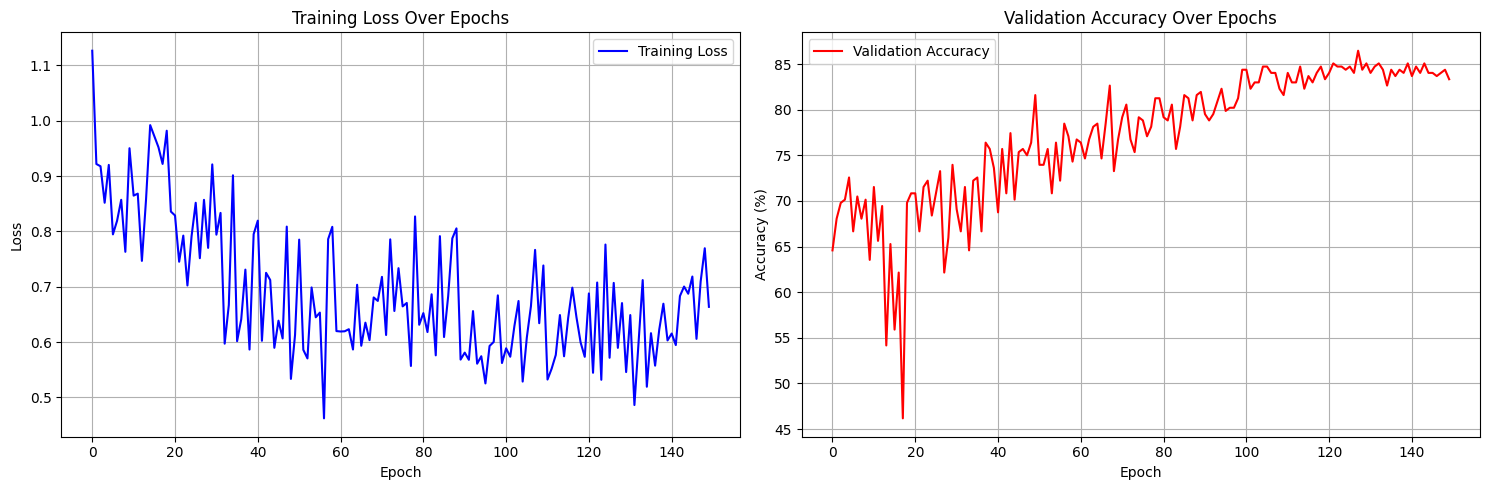


Final Results:
Best Validation Accuracy: 86.46%
Final Training Loss: 0.6637


In [8]:
# Plot training loss and validation accuracy
plt.figure(figsize=(15, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, 'r-', label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Results:")
print(f"Best Validation Accuracy: {max(test_accuracies):.2f}%")
print(f"Final Training Loss: {train_losses[-1]:.4f}")

## Confusion Matrix

The confusion matrix shows:
- Rows: True emotions
- Columns: Predicted emotions
- Numbers: Count of predictions
- Diagonal: Correct predictions
- Off-diagonal: Misclassifications

This helps identify which emotions are commonly confused with each other.

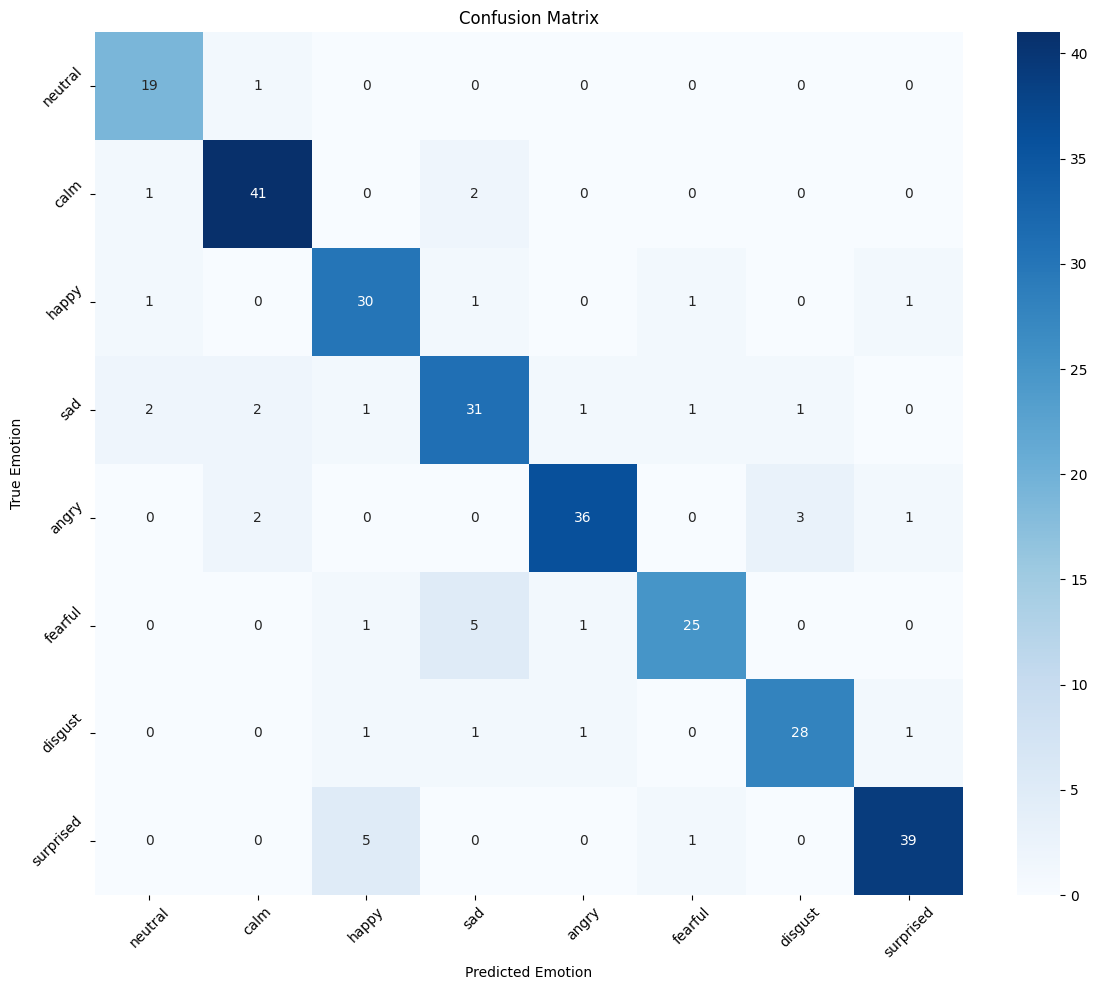


Confusion Matrix Analysis:
Total Correct Predictions: 249
Total Samples: 288
Overall Accuracy: 86.46%

Per-class Accuracy:
neutral: 95.00%
calm: 93.18%
happy: 88.24%
sad: 79.49%
angry: 85.71%
fearful: 78.12%
disgust: 87.50%
surprised: 86.67%


In [9]:
# Create and plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(epoch_targets, epoch_predictions)

# Create confusion matrix plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Print overall metrics
total_correct = np.sum(np.diag(cm))
total_samples = np.sum(cm)
print(f"\nConfusion Matrix Analysis:")
print(f"Total Correct Predictions: {total_correct}")
print(f"Total Samples: {total_samples}")
print(f"Overall Accuracy: {100 * total_correct / total_samples:.2f}%")

# Calculate per-class accuracy
print("\nPer-class Accuracy:")
for i, emotion in enumerate(emotion_labels):
    class_correct = cm[i, i]
    class_total = np.sum(cm[i, :])
    if class_total > 0:
        class_accuracy = 100 * class_correct / class_total
        print(f"{emotion}: {class_accuracy:.2f}%")